In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline


Bad key text.latex.preview in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quetzal.model import stepmodel
from quetzal.io import excel

# Validate endogenous volumes against those from VP2030

In [3]:
input_path = '../input/'
network_path = '../input_static/'
output_path = '../output/'
model_path = '../model/' + scenario + '/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
sm = stepmodel.read_json(model_path + 'de_zones')

In [6]:
segments = [s.strip() for s in params['general']['demand_segments'].split(';')]
purposes = [s.split('_')[0] for s in segments][::2]

In [7]:
# Load old volumes
volumes_file = 'de_volumes_exo'
v = stepmodel.read_zippedpickles(model_path + volumes_file)
# Rename columns from VP2030 to match the model's demand segments
car_segment_dict = {'0': '_no_car', '1': '_car'}
vp_purpose_dict = {'Fz1': 'commuting', 'Fz2': 'education', 'Fz3': 'buy/execute',
                   'Fz4': 'business', 'Fz6': 'leisure'}
sm.volumes = v.volumes.rename(columns={
    c: vp_purpose_dict[c.split('_')[0]]+car_segment_dict[c.split('_')[-1]]
    for c in v.volumes.columns if c.startswith('Fz')
})
# Create demand segment 'accompany' from 'Fz6' (private) with MiD2017 shares
accompany_no_car_share = 101 / 1530
accompany_car_share = 5569 / 30292
sm.volumes['accompany'+car_segment_dict['0']] = \
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['0']] * accompany_no_car_share
sm.volumes['accompany'+car_segment_dict['1']] = \
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['1']] * accompany_car_share
sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['0']] = \
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['0']] * (1-accompany_no_car_share)
sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['1']] = \
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['1']] * (1-accompany_car_share)

volumes: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.31it/s]


In [8]:
# Sum of old volumes (inter-zonal)
sm.volumes.loc[sm.volumes['origin']!=sm.volumes['destination'], segments].sum().sum() / 1e9

18.791316698650146

In [9]:
# Sum of old volumes (inner-zonal)
sm.volumes.loc[sm.volumes['origin']==sm.volumes['destination'], segments].sum().sum() / 1e9

2.505821251176618

In [56]:
# Load endogenously generated volumes
new = stepmodel.read_zippedpickles(model_path + 'de_volumes')

volumes: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.42s/it]


In [57]:
# Sum of new volumes
vol_sum = new.volumes.loc[new.volumes['origin']!=new.volumes['destination']
                         ].set_index(['origin', 'destination']).sum(axis=1).rename('vol')
vol_sum.sum() / 1e9

17.74792990401351

In [58]:
# Sum of new volumes (inner-zonal)
new.volumes.loc[new.volumes['origin']==new.volumes['destination'], segments].sum().sum() / 1e9

20.05546457067147

In [13]:
# Difference in OD sets
od_new = set([(o,d) for o,d in zip(new.volumes['origin'], new.volumes['destination'])])
od_vol = set([(o,d) for o,d in zip(sm.volumes['origin'], sm.volumes['destination'])])
len(od_vol - od_new)

31

In [14]:
len(od_vol)

42422

In [15]:
# Load the calibration dataset for validation
mid2017 = pd.read_csv(input_path + 'transport_demand/calibration_inter-cellular_trips_MiD2017.csv')
# Replace LAU codes with NUTS IDs
assert str(mid2017.loc[0, 'origin']).startswith('DE')
# Rename modes and purposes
mode_dict_mid = {1: 'rail_short', 2: 'rail_long',
                 3: 'coach', 4: 'bus', 5: 'air', 6: 'car', 7: 'walk'}
mid2017['mode_model'] = mid2017['mode_model'].map(mode_dict_mid)
mid2017['purpose_model'] = mid2017['purpose_model'].apply(lambda s: s.split('_')[0])

In [16]:
# Load VP2030 data for validation
vp2017 = pd.read_csv(network_path + 'vp2017_validation_normalised.csv')
# Restrict to inter-cell traffic and cells of the model
vp2017 = vp2017.loc[(vp2017['origin']!=vp2017['destination']) &
                    (vp2017['origin'].notna()) &
                    (vp2017['destination'].notna())]
vp2017 = vp2017.groupby(['origin', 'destination']).sum()
mode_dict_vp = {'Bahn': 'rail', 'MIV': 'car', 'Luft': 'air', 'OESPV': 'bus', 'non': 'walk'}
vp2017.columns = pd.MultiIndex.from_tuples(
    [(col.split('_')[-1], mode_dict_vp[col.split('_')[0]]) for col in vp2017.columns],
    names=['segment', 'mode'])
# Aggregate by purpose
vp2017 = vp2017.groupby('segment', axis=1).sum().rename(columns=vp_purpose_dict)
vp2017.reset_index(inplace=True)

In [17]:
# Load distances
distances = pd.read_csv(output_path + 'distances_centroids.csv')
'''island_dict = sm.zones.loc[['outer_1', 'outer_2'], 'NUTS_ID'].to_dict()
distances['o'] = distances['origin'].replace(island_dict).str[:5]
distances['d'] = distances['destination'].replace(island_dict).str[:5]
distances_agg = distances.groupby(['o', 'd']).agg({'length': 'mean'})
distances_agg.index.set_names(['origin', 'destination'], inplace=True)
distances = distances.drop(['o', 'd'], axis=1).set_index(['origin', 'destination'])'''
distances = distances.set_index(['origin', 'destination'])

In [21]:
# Load CC, which builds the deterrence matrix for constrained distribution
cc = pd.read_csv(output_path + scenario + '/mode_choice_od_composite_cost.csv')

## Validation

In [59]:
# Inner- and inter-zonal volumes by segment
seg_df = pd.DataFrame()
seg_df['exo_inner'] = sm.volumes.loc[sm.volumes['origin']==sm.volumes['destination'],
                                     segments].sum()
seg_df['exo_inter'] = sm.volumes.loc[sm.volumes['origin']!=sm.volumes['destination'],
                                     segments].sum()
seg_df['endo_inner'] = new.volumes.loc[new.volumes['origin']==new.volumes['destination'],
                                       segments].sum()
seg_df['endo_inter'] = new.volumes.loc[new.volumes['origin']!=new.volumes['destination'],
                                       segments].sum()

<AxesSubplot:>

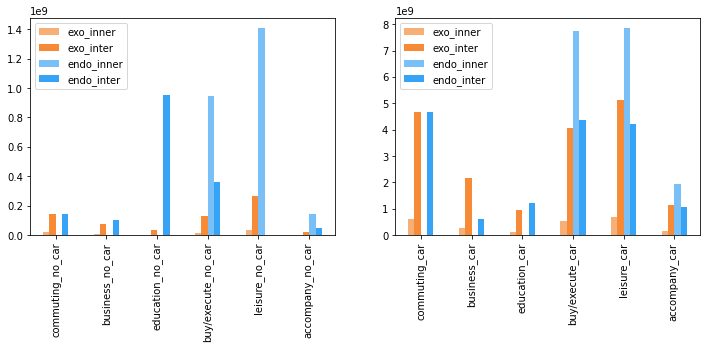

In [60]:
# Compare inner- and inter-zonal volumes by segment
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
seg_df.loc[[s for s in segments if '_no_car' in s]].plot.bar(
    legend=True, color=['#f7af78', '#f68a37', '#78c0f7', '#37a3f6'], ax=ax[0])
seg_df.loc[[s for s in segments if not '_no_car' in s]].plot.bar(
    legend=True, color=['#f7af78', '#f68a37', '#78c0f7', '#37a3f6'], ax=ax[1])

In [37]:
# Define distance classes
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 200, 300, 500, 1000]
labels = ['{}-{}km'.format(bins[i], bins[i+1]) for i in range(len(bins)-1)]

In [61]:
# Assign distances to volumes
for df in [new.volumes, sm.volumes, vp2017, mid2017, cc]:
    df['dist'] = df.set_index(['origin', 'destination']).index.map(distances.to_dict()['length'])
    df['bins'] = pd.cut(df['dist'], bins=bins, labels=labels)

<AxesSubplot:xlabel='bins'>

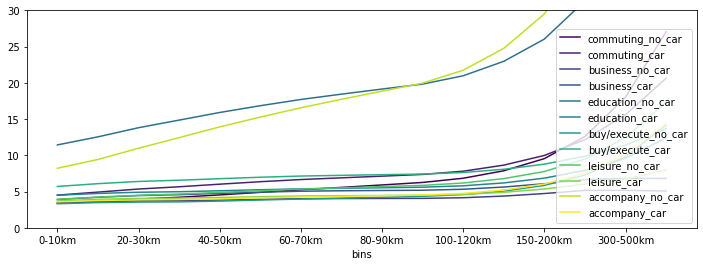

In [39]:
# Look at the CC over distance by segment (builds the deterrence matrix)
cc.loc[cc.notna().all(axis=1)].groupby('bins')[segments].mean().plot.line(
    legend=True, figsize=(12,4), colormap='viridis', ylim=(0,30))

In [62]:
# Sum up volumes of the model and VP2030
vol_df = pd.DataFrame()
for car in car_segment_dict.values():
    segs = [s for s in segments if s.endswith(car)]
    vol_df['endo'+car] = new.volumes.groupby('bins').sum()[segs].sum(axis=1)
    vol_df['exo'+car] = sm.volumes.groupby('bins').sum()[segs].sum(axis=1)
vol_df['endo'] = new.volumes.groupby('bins').sum()[segments].sum(axis=1)
vol_df['exo'] = sm.volumes.groupby('bins').sum()[segments].sum(axis=1)

<AxesSubplot:xlabel='bins'>

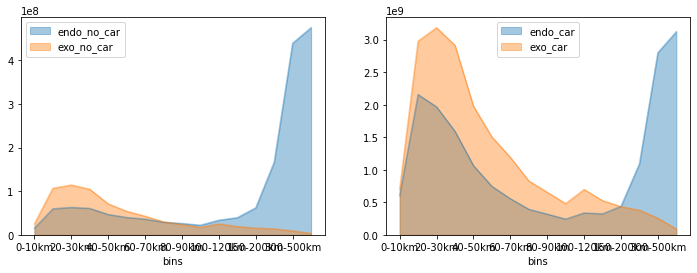

In [63]:
# plot
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
vol_df[['endo_no_car', 'exo_no_car']].plot(kind='area', stacked=False, alpha=.4, ax=ax[0])
vol_df[['endo_car', 'exo_car']].plot(kind='area', stacked=False, alpha=.4, ax=ax[1])

<AxesSubplot:xlabel='bins'>

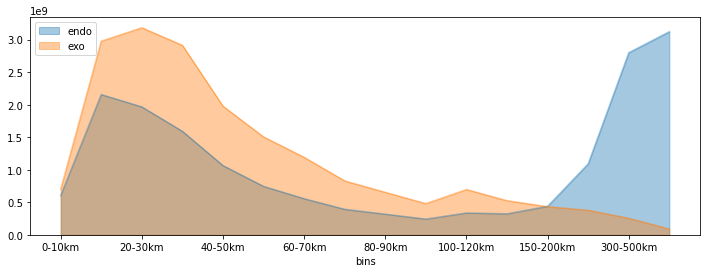

In [64]:
# plot total
vol_df[['endo', 'exo']].plot(kind='area', stacked=False, alpha=.4, figsize=(12,4))

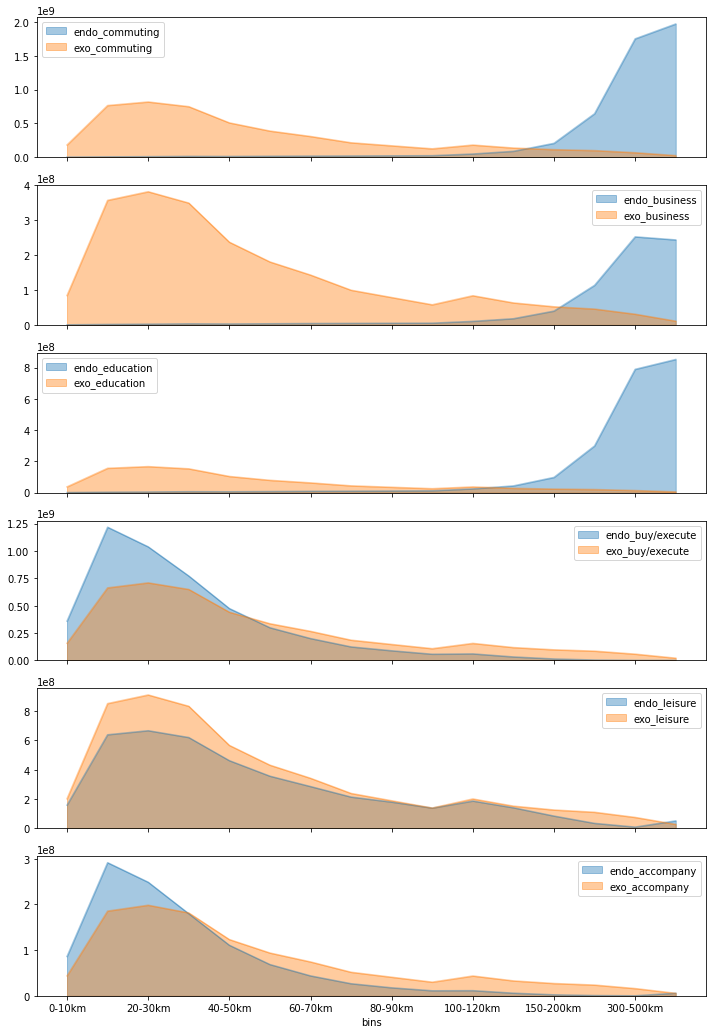

In [65]:
# plot by purpose
fig, ax = plt.subplots(ncols=1, nrows=len(purposes), figsize=(12,len(purposes)*3), sharex='all')
i = 0
for p in purposes:
    vol_df['endo_'+p] = new.volumes.groupby('bins').sum()[[s for s in segments if p in s]].sum(axis=1)
    vol_df['exo_'+p] = sm.volumes.groupby('bins').sum()[[s for s in segments if p in s]].sum(axis=1)
    vol_df[['endo_'+p, 'exo_'+p]].plot(kind='area', stacked=False, alpha=.4, ax=ax[i])
    i += 1

In [66]:
# Scale to VP2030 levels
vol_df['VP2030'] = vp2017.loc[vp2017['bins'].notna()].groupby('bins').sum()[
    ['commuting', 'education', 'buy/execute', 'business', 'leisure']
].sum(axis=1)
vol_df['endo'] /= vol_df['endo'].mean() / vol_df['VP2030'].mean()
vol_df['exo'] /= vol_df['exo'].mean() / vol_df['VP2030'].mean()

<AxesSubplot:xlabel='bins'>

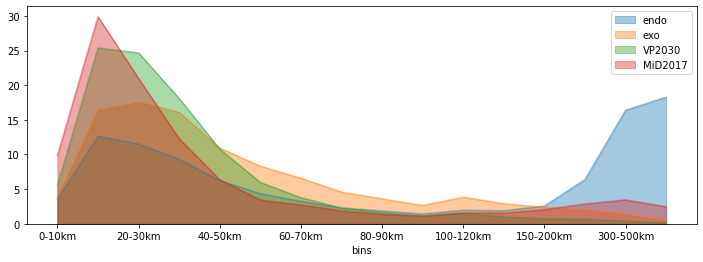

In [69]:
# plot with VP2030
vol_df[[c for c in vol_df.columns if not '_' in c]].plot(
    kind='area', stacked=False, alpha=.4, figsize=(12,4))

In [70]:
# Add MiD2017
vol_df['MiD2017'] = mid2017.loc[mid2017['bins'].notna()].groupby('bins').size()
vol_df['MiD2017'] /= vol_df['MiD2017'].mean() / vol_df['VP2030'].mean()

<AxesSubplot:xlabel='bins'>

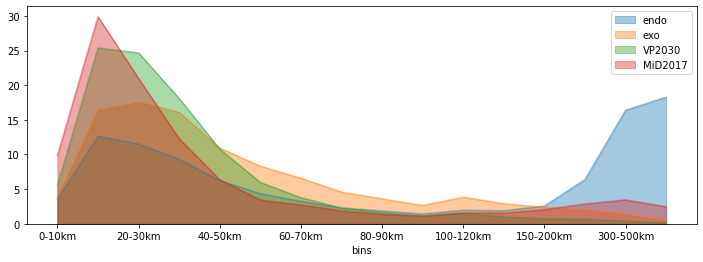

In [71]:
# plot with VP2030
vol_df[[c for c in vol_df.columns if not '_' in c]].plot(
    kind='area', stacked=False, alpha=.4, figsize=(12,4))